# IM(G): One time ComCam Image Ingestion and MTAOS Correction

This notebook is used to execute the [LVV-T2228 (1.0)] test script during System Spread Integration Tests on Level 3.  
It is part of the plan [LVV-P81] and of the test cycle [LVV-C176].   
Execution steps are separated by horizontal lines.   
Upon completion, save the notebook and its output as a pdf file to be attached to the test execution in JIRA.  

In summary, you slew to a target and start tracking. Then you find the Wavefront Error as Zernike Coefficients,  
convert them to corrections to be applied to M1M3, M2, Camera Hexapod and M2 Hexapod. Finally you stop tracking. 
  
[LVV-T2228 (1.0)]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T2228  
[LVV-T2229 (1.0)]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/2604  
[LVV-P81]: https://jira.lsstcorp.org/secure/Tests.jspa#/testPlan/LVV-P81  
[LVV-C176]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCycle/LVV-C176  

In [17]:
from lsst.ts import utils
import yaml


# Extract your name from the Jupyter Hub
__executed_by__ = os.environ["JUPYTERHUB_USER"]  

# Extract execution date
__executed_on__ = utils.astropy_time_from_tai_unix(utils.current_tai())
__executed_on__.format = "isot"

# This is used later to define where Butler stores the images
summit = os.environ["LSST_DDS_PARTITION_PREFIX"] == "summit"

print(f"\nExecuted by {__executed_by__} on {__executed_on__}."
      f"\n  At the summit? {summit}")


Executed by isotuela on 2022-05-13T17:48:52.508.
  At the summit? True


***

## Initial Setup

log onto the summit nublado  
https://summit-lsp.lsst.codes/  
git clone the ts_notebook repo  

There will be a series of procedures to set up, "slew" and track the telescope before we get an image.    
This is similar to test case [LVV-T2189](https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T2189).   

***

## Check ComCam Playback Mode

Verify that ComCam can be use the playback option and that the required images are stored in the right place **TBD**.

---
## Load all the needed libraries

Using the setup procedure, get the remotes and the components ready.

This includes simulators as well as real hardware when available (this will depend on when the test is conducted at NCSA or on level 3 or on the telescope):

- pointing  
- mount ( with the CCW)  
- rotator  
- ready M1M3: raise mirror, turn on FB, clear forces. Note that if used at level 3, we need to have M1M3 LUT use mount telemetry  
- ready M2: turn on FB, clear forces. Note that if used at level 3, we need to have M2 LUT use mount telemetry  
- Get cam hex Ready: check config; make sure LUT is on and has valid inputs; make sure hex is at LUT position  
- Get M2 hex (simulator) Ready: check config; make sure LUT is on and has valid inputs; make sure hex is at LUT position  
- Finally, get the MTAOS CSC ready  

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import rubin_jupyter_utils.lab.notebook as nb
nb.utils.get_node()

/tmp/ipykernel_19312/1665379685.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) get_node. (Please use lsst.rsp.get_node())
  nb.utils.get_node()


'yagan06'

In [20]:
import os
import sys
import asyncio
import logging

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import lsst.daf.butler as dafButler

from lsst.ts import salobj
from lsst.ts.observatory.control.maintel import MTCS, ComCam
from lsst.ts.observatory.control import RotType

In [21]:
logging.basicConfig(format="%(name)s:%(message)s", level=logging.DEBUG)

In [22]:
log = logging.getLogger("setup")
log.level = logging.DEBUG

In [23]:
domain = salobj.Domain()

In [24]:
mtcs = MTCS(domain=domain, log=log)
mtcs.set_rem_loglevel(40)

In [25]:
await mtcs.start_task

[None, None, None, None, None, None, None, None, None, None]

In [26]:
comcam = ComCam(domain=domain, log=log)
comcam.set_rem_loglevel(40)

In [27]:
await comcam.start_task

[None, None, None]

In [12]:
await comcam.enable()

In [34]:
await mtcs.enable()

---
## Slew and Track


Using the slew procedure, slew the systems to a specific elevation, azimuth and rotator angle.
Verify that the telemetry is generated.

Slew to **RA 20:28:18.74** and **DEC -87:28:19.9** with **rot_type=RotType.Physical** and **Rotator Angle of 0º**.
We use this field because it is the field that was simulated and that is a field that is visible the whole year.

RotType Physical Ensures that the Rotator will not move.
This is necessary because the CCW is not running (MTmount in simulation mode).

Slew to target:

In [35]:
await mtcs.slew_icrs(ra="20:28:18.74", dec="-87:28:19.9", rot_type=RotType.Sky, rot=0)

(<ICRS Coordinate: (ra, dec) in deg
     (307.07808333, -87.47219444)>,
 <Angle 0. deg>)

***
## Take in-focus image

Once the different components are ready (M1M3, M2, rotator and CCW, hexapods) and tracking, take an image using the take_image command in playback mode.  
This second image should be the one that uses the correction calculated with the first slew.

In [36]:
exp_focus = await comcam.take_object(15)
print(f"Target exposure: {exp_focus}")

Target exposure: [2022051300008]


----
## Intra Focus Position 

Using the Camera Hexapod, piston ComCam +1mm

In [37]:
await mtcs.move_camera_hexapod(x=0,y=0,z=1000,u=0,v=0, w=0)

----
## Intra Focus Image


While tracking, take an image with ComCam and check that the header is containing the right telemetry

In [38]:
exp_intra = await comcam.take_object(15)
print(f"Target 1 exposure: {exp_intra}")

Target 1 exposure: [2022051300009]


---
## Extra Focus Position

Using the Camera Hexapod, piston ComCam to -1mm

In [39]:
await mtcs.move_camera_hexapod(x=0,y=0,z=-1000,u=0,v=0, w=0)

---
## Extra Focus Image

While tracking, take an image with ComCam and check that the header is containing the right telemetry.

In [40]:
exp_extra = await comcam.take_object(15)
print(f"Target 1 exposure: {exp_extra}")

Target 1 exposure: [2022051300010]


---
## Go Back to Focus Position

Put the hexapod back to 0mm.

In [41]:
await mtcs.move_camera_hexapod(x=0,y=0,z=0,u=0,v=0, w=0)

---
## Stop Tracking

If using MTMount Simulator and CCW Following Mode Disabled, stop tracking to prevent the Rotator to hit the limit switches.

In [42]:
await mtcs.stop_tracking()

---
## Get Zernike Coefficients

Use the MTAOS Wavefront Estimator Pipeline to calculate the required Zernike Coefficients that represent the Wavefront data.

In [44]:
wep_config = yaml.safe_dump(
    dict(
        tasks=dict(
            isr=dict(
                 config=dict(
                     doOverscan=False, 
                     doApplyGains=False,
                 ) 
            ),
            generateDonutCatalogWcsTask=dict(
                config={
                    "filterName":"phot_g_mean",
                    "connections.refCatalogs": "gaia_dr2_20200414",
                    "donutSelector.sourceLimit": 10,
                    "donutSelector.fluxField": "phot_g_mean_flux"                       
                }
            )
        ) 
    )
)

In [45]:
await mtcs.rem.mtaos.cmd_runWEP.set_start(visitId=exp_intra[0], 
                                          extraId=exp_extra[0],
                                         config = wep_config)

---
## Get Corrections

Use the MTAOS Optical Feedback Controller to retrieve the corrections that should be applied to m1m3, m2, camera hexapod, and m2 hexapod.

In [46]:
await mtcs.rem.mtaos.cmd_runOFC.start(timeout=60.)

---
## Issue the corrections

Issue the corrections found by the MTAOS OFC to m1m3, m2, camera hexapod, and m2 hexapod. 

In [47]:
await mtcs.rem.mtaos.cmd_issueCorrection.start(timeout=60.)

***
## Verify ISR Data

Make sure that the Instrument Signature Removal ran on the intra- and extra-focus data and that this data is accessible via Butler.

In [48]:
if summit:
    butler = dafButler.Butler("/repo/LSSTComCam/")
else:
    butler = dafButler.Butler("/repo/main/")

In [49]:
registry = butler.registry

collections = [collection for collection in registry.queryCollections() 
               if collection.startswith('mtaos_wep')]

In [50]:
exp_intra_id = {'instrument': 'LSSTComCam', 
                'detector': 0, 
                'exposure': exp_intra[0]}

raw_intra = butler.get('postISRCCD', dataId=exp_intra_id, 
                       collections=collections)

print(raw_intra.getMetadata())

DATE = "2022-05-13T17:56:59.912"
// Creation Date and Time of File
MJD = 59712.747915648
// Modified Julian Date that the file was written
CCD_MANU = "ITL"
// CCD Manufacturer
CCD_TYPE = "3800C"
// CCD Model Number
TESTTYPE = "OBJECT"
// BIAS, DARK, FE55, FLAT, LAMBDA, PERSISTENCE, SP
IMGTYPE = "OBJECT"
// BIAS, DARK, FE55, FLAT, FLAT_<lam>, SPOT, PPUMP
FILENAME = "CC_O_20220513_000009_R22_S00.fits"
// Original name of the file
BINX = 1
// [pixels] binning along X axis
BINY = 1
// [pixels] binning along Y axis
CCDGAIN = 1.0000000000000
// Rough guess at overall system gain (e-/DNB)
CCDNOISE = 10.000000000000
// Rough guess at system noise (e- rms)
DATE-TRG = "2022-05-13T17:56:22.910"
// Date of the image trigger (readout), UTC f
MJD-TRG = 59712.747487384
// Modified Julian Date of image trigger
IMAGETAG = "d5dbeb4c5ab3868"
// DAQ Image id (Hex)
CCDSLOT = "S00"
// The CCD Slot
RAFTBAY = "R22"
// The RAFT Bay
FIRMWARE = "302c5003"
// DAQ firmware version (Hex)
PLATFORM = "comcam"
// DAQ 

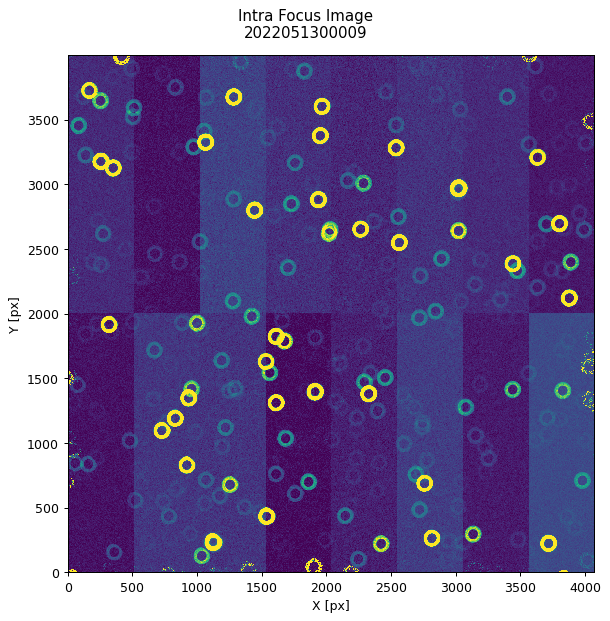

In [51]:
%matplotlib inline
fig, ax = plt.subplots(num="Intra Focus Image", figsize=(7,7), dpi=90)

vmin = np.percentile(raw_intra.image.array, 2)
vmax = np.percentile(raw_intra.image.array, 98)

ax.imshow(raw_intra.image.array, 
          origin='lower', 
          interpolation='nearest', 
          vmin=vmin, 
          vmax=vmax)
ax.set_xlabel("X [px]")
ax.set_ylabel("Y [px]")

fig.suptitle(f"Intra Focus Image\n{exp_intra_id['exposure']}")
fig.tight_layout()

plt.show()

In [52]:
exp_extra_id = {'instrument': 'LSSTComCam', 
                'detector': 0, 
                'exposure': exp_extra[0]}

exp_extra = butler.get('postISRCCD', dataId=exp_extra_id, 
                       collections=collections)

print(exp_extra.getMetadata())

DATE = "2022-05-13T17:57:25.928"
// Creation Date and Time of File
MJD = 59712.748216759
// Modified Julian Date that the file was written
CCD_MANU = "ITL"
// CCD Manufacturer
CCD_TYPE = "3800C"
// CCD Model Number
TESTTYPE = "OBJECT"
// BIAS, DARK, FE55, FLAT, LAMBDA, PERSISTENCE, SP
IMGTYPE = "OBJECT"
// BIAS, DARK, FE55, FLAT, FLAT_<lam>, SPOT, PPUMP
FILENAME = "CC_O_20220513_000010_R22_S00.fits"
// Original name of the file
BINX = 1
// [pixels] binning along X axis
BINY = 1
// [pixels] binning along Y axis
CCDGAIN = 1.0000000000000
// Rough guess at overall system gain (e-/DNB)
CCDNOISE = 10.000000000000
// Rough guess at system noise (e- rms)
DATE-TRG = "2022-05-13T17:56:48.925"
// Date of the image trigger (readout), UTC f
MJD-TRG = 59712.747788484
// Modified Julian Date of image trigger
IMAGETAG = "7d4925e967ffcb62"
// DAQ Image id (Hex)
CCDSLOT = "S00"
// The CCD Slot
RAFTBAY = "R22"
// The RAFT Bay
FIRMWARE = "302c5003"
// DAQ firmware version (Hex)
PLATFORM = "comcam"
// DAQ

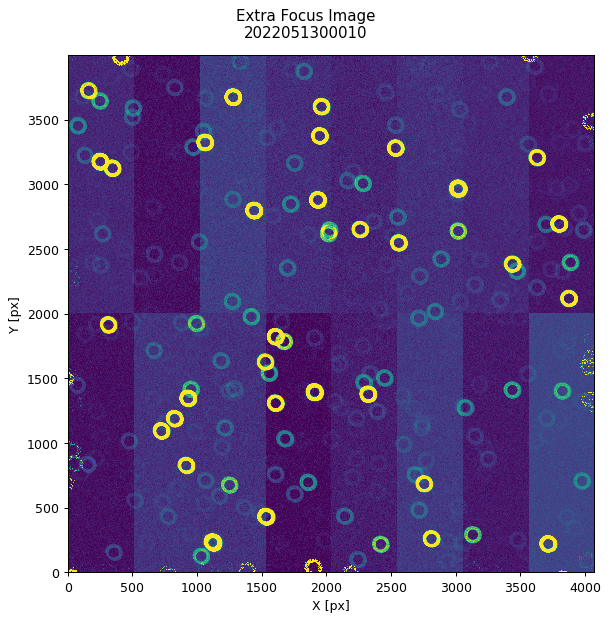

In [53]:
%matplotlib inline
fig, ax = plt.subplots(num="Extra Focus Image", figsize=(7, 7), dpi=90)

vmin = np.percentile(exp_extra.image.array, 2)
vmax = np.percentile(exp_extra.image.array, 98)

ax.imshow(exp_extra.image.array, 
          origin='lower', 
          interpolation='nearest', 
          vmin=vmin, 
          vmax=vmax)

ax.set_xlabel("X [px]")
ax.set_ylabel("Y [px]")

fig.suptitle(f"Extra Focus Image\n{exp_extra_id['exposure']}")
fig.tight_layout()

plt.show()

***
## Wrap Up and Shut Down

This section is intended for shutting down the system and should not be run as part of the regular testing procedure. 
Only run the following cells if you are done with the system and don't plan on executing any further tests.

In [ ]:
await mtcs.set_state(salobj.State.STANDBY, components=["mtaos"])

In [ ]:
await mtcs.lower_m1m3()

In [ ]:
await mtcs.set_state(salobj.State.STANDBY, components=["mtm1m3"])

In [ ]:
await mtcs.set_state(salobj.State.STANDBY, components=["mtm2"])

In [ ]:
await mtcs.set_state(salobj.State.STANDBY, components=["mthexapod_1"])

In [ ]:
await mtcs.set_state(salobj.State.STANDBY, components=["mthexapod_2"])

In [ ]:
await mtcs.standby()

In [ ]:
await comcam.standby()